In [ ]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import time
import re
import pickle
from string import punctuation
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns

In [ ]:
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Kaggle/News-Category/dataset/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# 2. Remove punctiation & convert to lowercase:
data['headline_processed'] = data.headline.str.replace('[{}]'.format(string.punctuation), '').str.lower()
data['short_description_processed'] = data.short_description.str.replace('[{}]'.format(string.punctuation), '').str.lower()
data['authors_processed'] = data.authors.str.replace('[{}]'.format(string.punctuation), '').str.lower()

In [ ]:
def category_cleaner(x):
    
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    else:
        return x

In [ ]:
# deal with category
data['category'] = data.category.apply(category_cleaner)


le = LabelEncoder()
data_labels = le.fit_transform(data.category)

In [ ]:
data['text'] = data['headline_processed'] + data['short_description_processed'] + data['authors_processed']

In [ ]:
df = data[['category', 'text']]

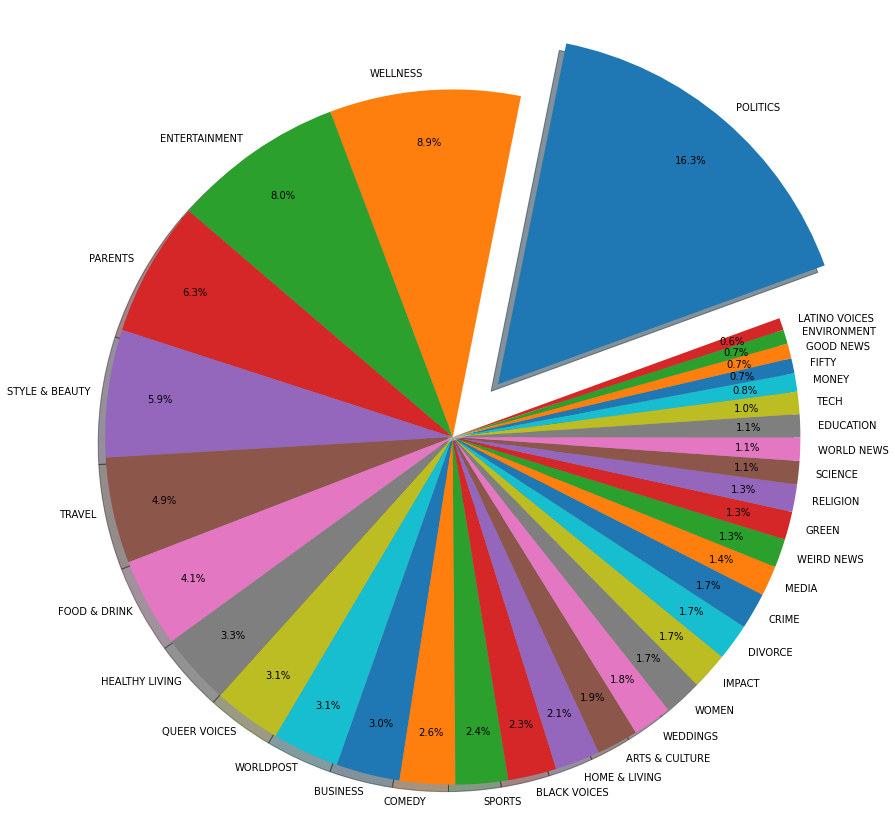

In [ ]:
plt.figure(figsize=(15,15))
sizes = df.category.value_counts().values
labels = df.category.value_counts().index
plt.pie(sizes, labels=labels, autopct='%.1f%%',
        shadow=True, pctdistance=0.85, labeldistance=1.05, startangle=20, 
        explode = [0 if i > 0 else 0.2 for i in range(len(sizes))])
plt.axis('equal')
plt.show()

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

## Tokenizing and Padding

In [ ]:
X,Y = df['text'],df['category']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [ ]:
vocab_size =20000
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
import tensorflow as tf


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)

(160682, 150)
(160682, 34)
(20085, 150)
(20085, 34)


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip #downloadingu glove vec word embeddings

In [ ]:
# !unzip -q glove.6B.zip #unzipping 

In [ ]:
# path_to_glove_file =  './glove.6B.100d.txt'

In [ ]:
# #Initialising the embedding matrix with glove vec embeddings

# num_tokens = len(tokenizer.word_index.items()) + 2
# embedding_dim = 100
# hits = 0
# misses = 0


# embeddings_index = {}
# with open(path_to_glove_file) as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         embeddings_index[word] = coefs

# print("Found %s word vectors." % len(embeddings_index))


# # Prepare embedding matrix
# embedding_matrix = np.zeros((num_tokens, embedding_dim))
# for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in embedding index will be all-zeros.
#         # This includes the representation for "padding" and "OOV"
#         embedding_matrix[i] = embedding_vector
#         hits += 1
#     else:
#         misses += 1
# print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)

num_tokens = len(tokenizer.word_index.items()) + 2
tf.keras.backend.clear_session()
embed_size = 100
embedding_dim = 100
# hits = 0
# misses = 0
model = keras.models.Sequential([
                                 
        Embedding(num_tokens,
        embedding_dim,
        mask_zero=True,input_shape=[None],trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(256, dropout = 0.4)),
        keras.layers.Dense(34, activation="softmax")
            
        ])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         33302600  
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dense (Dense)                (None, 34)                17442     
Total params: 34,051,178
Trainable params: 748,578
Non-trainable params: 33,302,600
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit( train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32, 
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=50,
                     callbacks=  early_stop )

Epoch 1/50
5021/5021 [==============================] - 123s 23ms/step - loss: 2.8391 - accuracy: 0.2363 - val_loss: 2.2189 - val_accuracy: 0.3959
Epoch 2/50
5021/5021 [==============================] - 111s 22ms/step - loss: 2.1876 - accuracy: 0.4036 - val_loss: 1.9345 - val_accuracy: 0.4829
Epoch 3/50
5021/5021 [==============================] - 111s 22ms/step - loss: 1.9710 - accuracy: 0.4654 - val_loss: 1.7899 - val_accuracy: 0.5196
Epoch 4/50
5021/5021 [==============================] - 112s 22ms/step - loss: 1.8352 - accuracy: 0.5002 - val_loss: 1.6918 - val_accuracy: 0.5424
Epoch 5/50
5021/5021 [==============================] - 112s 22ms/step - loss: 1.7240 - accuracy: 0.5317 - val_loss: 1.6099 - val_accuracy: 0.5661
Epoch 6/50
5021/5021 [==============================] - 112s 22ms/step - loss: 1.6304 - accuracy: 0.5561 - val_loss: 1.5251 - val_accuracy: 0.5933
Epoch 7/50
5021/5021 [==============================] - 112s 22ms/step - loss: 1.5378 - accuracy: 0.5807 - val_loss: 1

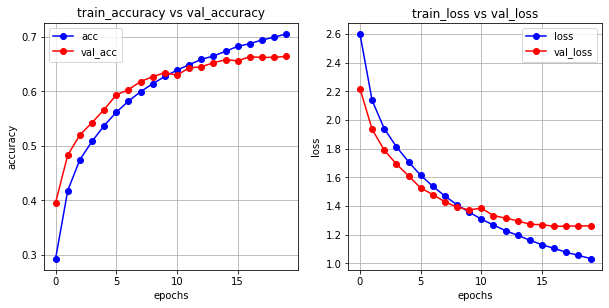

In [ ]:
 fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

In [ ]:
classes = df['category'].value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()                
    return pred_value

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       388
           1       0.60      0.45      0.52       430
           2       0.47      0.42      0.44       600
           3       0.79      0.49      0.60       500
           4       0.49      0.50      0.50       347
           5       0.82      0.55      0.66       309
           6       0.54      0.46      0.50       228
           7       0.71      0.73      0.72      1607
           8       0.64      0.33      0.44       132
           9       0.72      0.59      0.65       145
          10       0.79      0.79      0.79       834
          11       0.65      0.45      0.53       162
          12       0.50      0.27      0.35       245
          13       0.56      0.62      0.59       673
          14       0.88      0.70      0.78       444
          15       0.31      0.35      0.33       358
          16       0.88      0.43      0.57       131
          17       0.79    

Text(0.5, 1.0, 'Confusion matrix of model')

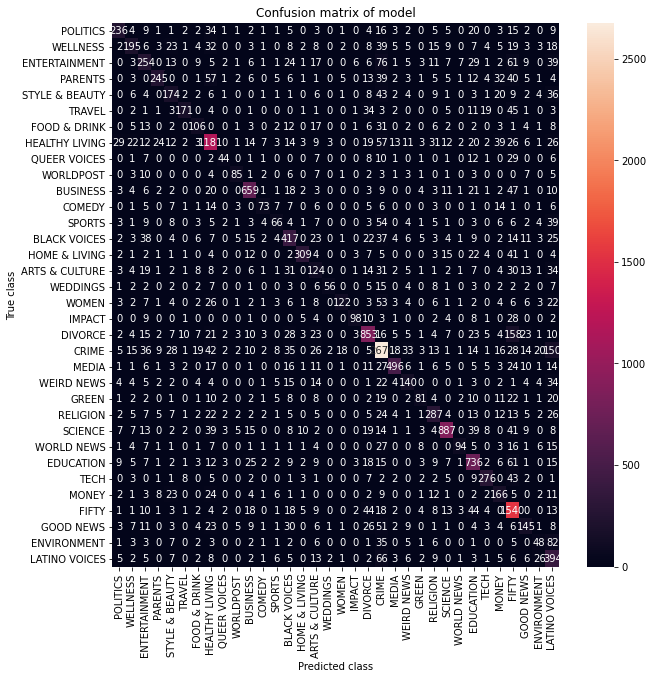

In [ ]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))
cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

In [ ]:
print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Accuracy: 0.6688240565568058
